### Step 5: Building the topographic $(d,u,v)$ space of $S_{ref}(x,y,z)$

Using $S(u,v)$, the $(u,v)$ parameterization of $S_{ref}(x,y,z)$ we can propagate the surface along the steepest gradient of its signed distance transform in desired stepsizes to map the surrounding 'normal' space external and internal to the cell. This produces a 'topographic' volume representation that is particularly useful for analysing surface features.

This workbook shows how to build the topographic space to enable a topographic surface to be extracted as well as to map the original Cartesian volume image into a topographic volume image.

#### 1. Load $S(x,y,z)$, $S_{\text{ref}}(x,y,z)$ and $S_{\text{ref}}(u,v)$

We assume the user has worked through step 4 which generates and saves the (u,v) parameterization of the reference surface $S_{ref}(x,y,z)$ for an input cell surface mesh to the folder `example_results/bleb_example/step4_uv_mapping`. We also need the original image and its segmentation in the folder `../../example_data/img`. 

In [1]:
import unwrap3D.Utility_Functions.file_io as fio
import unwrap3D.Mesh.meshtools as meshtools
import numpy as np
import os 
import skimage.io as skio 
import scipy.io as spio

# example cell used
imgfolder = '../../data/img'
imgfile = os.path.join(imgfolder, 'bleb_example.tif')
basefname = os.path.split(imgfile)[-1].split('.tif')[0] # get the filename with extension

# create the analysis save folder for this step
savefolder = os.path.join('example_results', 
                         basefname,
                         'step5_topographic_space')
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.

"""
Loading
"""
# original image
img_file = '../../data/img/%s.tif' %(basefname)
img = skio.imread(img_file)

# original binary image file
binary_img_file = 'example_results/%s/step0_cell_segmentation/%s_binary_seg.tif' %(basefname, basefname)
binary_img = skio.imread(binary_img_file)

# load the original surface which is used to determine the maximal extent to propagate out from the surface.
surf_file = 'example_results/%s/step0_cell_segmentation/curvature_binary_mesh_%s.obj' %(basefname, basefname)
surf_mesh = meshtools.read_mesh(surf_file)

# load the genus-0 S_ref reference mesh that was sphere mapped
surf_Sref_file = 'example_results/%s/step1_cMCF_reference/remapped_input_surface_onto_cMCF_Sref_mesh_H_color.obj' %(basefname)
surf_Sref_mesh = meshtools.read_mesh(surf_Sref_file)

# load the pre-computed uv-mapping of S_ref(x,y,z)
uv_folder = 'example_results/%s/step4_uv_mapping' %(basefname)
uv_file = os.path.join(uv_folder, 
                       'uv_mapping_params.mat')
uv_map_obj = spio.loadmat(uv_file) # reads the .mat like a python dictionary. 

S_uv = uv_map_obj['uv_map'].copy()

#### 2. Constructing the topographic space, $(d,u,v)$ of $S_{\text{ref}}(x,y,z)$

The topographic space normal to $S_{\text{ref}}(x,y,z)$ is constructed by propagating the uv-parameterized $S_{\text{ref}}(u,v)$, $D_{out}$ steps outwards until it covers the most extremal protrusions of $S(x,y,z)$ and $D_{in}$ steps into the cell along the gradient of a specified distance transform. The distance transform used to propagate outwards need not be the same as that used for propagating inwards. 

u-Unwrap3D computes the distance transform using the binary voxelization of the genus-0 $S_{\text{ref}}(x,y,z)$.  

##### a. specifying the stepsize

Choosing too small a stepsize means long computing times. Choose too large a stepsize means sampling the surface protrusions without sufficient resolution. 

By default, u-Unwrap3D attempts to set an optimal stepsize based on computing the mean voxel dimensions in 3D Cartesian space of a (u,v) pixel (`alpha_step=None`). Alternatively users may specify their own e.g. `alpha_step=1`.  

##### b. choice of distance transform

For outwards propagation, the shape of $S_{\text{ref}}(x,y,z)$ should be maintained, u-Unwrap3D recommends the Euclidean distance transform which is fast to compute, and forward Euler method of propagation `outer_method=forward_euler`.

For inwards propagation, if the shape of $S_{\text{ref}}(x,y,z)$ is convex without branches/protrusions, we can also use the Euclidean distance transform and forward Euler method of propagation as for outwards propagation. However, the shape of $S_{\text{ref}}(x,y,z)$ can have branches and protrusions, after cMCF. To handle also these cases u-Unwrap3D implements the harmonic distance transform, obtained by solving the Poisson equation, `inner_sdf_method = 'harmonic'` together with backward Euler method of propagation using active contours, `active_contours`.

In [2]:
import unwrap3D.Unzipping.unzip as uzip

"""
Get the binary of S_ref
"""
# Note If you saved the binary of S_ref, you can read this in, otherwise you need to voxelize the S_ref mesh. 
Sref_binary = meshtools.voxelize_image_mesh_pts(surf_Sref_mesh,
                                                dilate_ksize=2,
                                                erode_ksize=2,
                                                vol_shape=img.shape[:3][::-1]) # the transpose is because, we extracted its surface after transposing the binary.
S_mesh_pts = surf_mesh.vertices.copy()

topography_space, (N_in, N_out), alpha_step = uzip.build_topography_space_from_Suv(S_uv, 
                                                                                    Sref_binary,
                                                                                    external_gradient_field = None, # build if none, using Euclidean distance transform
                                                                                    pad_size=50, 
                                                                                    alpha_step=None, # use automatic method
                                                                                    outer_surf_pts = S_mesh_pts,
                                                                                    outer_n_dists = None, # let this be auto determined. 
                                                                                    outer_pad_dist=10, # the leeway.
                                                                                    outer_method='forward_euler',
                                                                                    outer_smooth_win_factor=16, # we will smooth by minimum length of uv divide this factor. 
                                                                                    inner_n_dists = 25, # in voxels.
                                                                                    inner_sdf_method = 'harmonic',
                                                                                    inner_source_mask = None, 
                                                                                    inner_harmonic_ds = 4., # harmonic distance transform is memory-intensive and slow. Nearly always we must downsample so the volume is at most 256 x 256 x 256 voxels. 4x downsample by default. 
                                                                                    inner_method='active_contours')

100%|██████████| 45/45 [00:11<00:00,  3.80it/s]


laplacian 3D construction... 2.926464319229126


100%|██████████| 25/25 [00:17<00:00,  1.46it/s]


We can doublecheck the propagation has been computed properly by visualizing the wireframe of the surface for different values of $d$. We don't need to plot every $d$, but sample it e.g. every 10 

topographic space dimension:  (71, 256, 512, 3)
the first 25 slices are interior of S_ref
the next 45 slices are exterior of S_ref


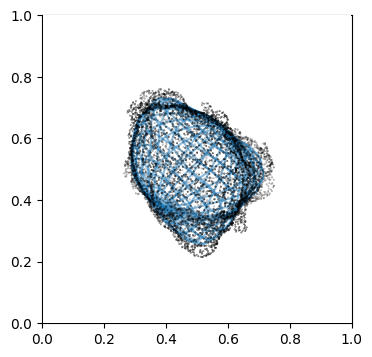

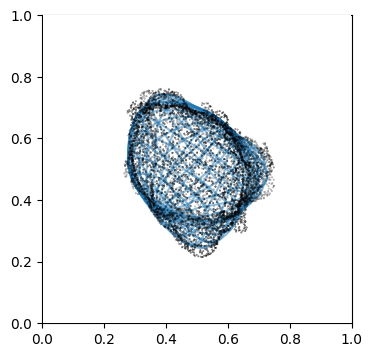

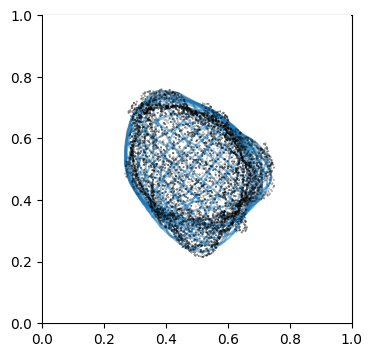

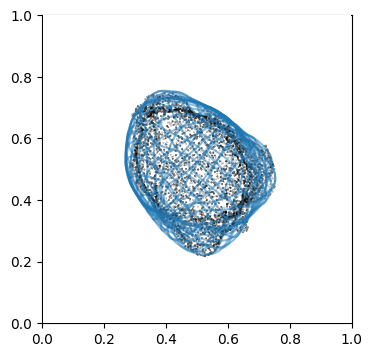

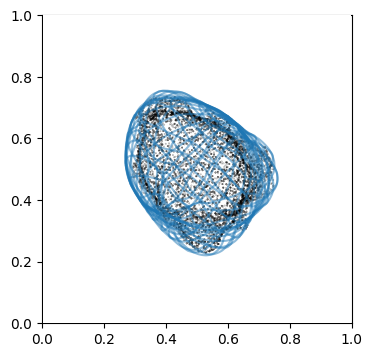

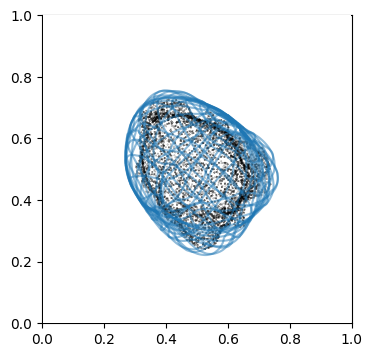

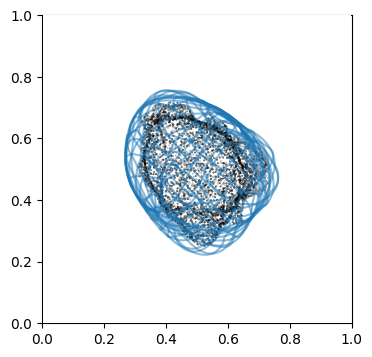

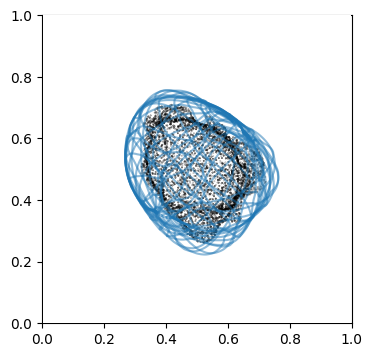

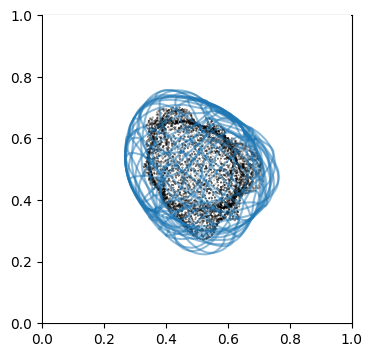

In [3]:
# check what is the dimensions of the topographic space

print('topographic space dimension: ', topography_space.shape)
print('the first %d slices are interior of S_ref' %(N_in))
print('the next %d slices are exterior of S_ref' %(N_out))


# use matplotlib and plot every 10th iteration wireframe surface to see the effect relative to the surface mesh.  
import pylab as plt 

"""
Visualize first the propagation outwards which is from N_in+1 onwards
"""
Suv_prop_outside = topography_space[N_in+1:]

sampling = 5

for ii in np.arange(0, len(Suv_prop_outside), sampling):
    fig, ax = plt.subplots(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')
    ax.set_box_aspect(aspect = (1,1,1)) # this works. 
    ax.scatter(surf_mesh.vertices[::sampling,0],
               surf_mesh.vertices[::sampling,1],
               surf_mesh.vertices[::sampling,2], color='k', s=0.1) # note the surface mesh vertices are inverse order to the image. 
    # plot the propagated surface.
    ax.plot_wireframe(Suv_prop_outside[ii][...,0], 
                      Suv_prop_outside[ii][...,1],
                      Suv_prop_outside[ii][...,2], rstride=16, cstride=16, alpha=0.5)
    ax.axis('off')
    ax.grid('off')
    plt.show()

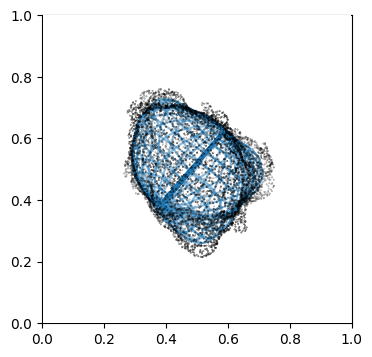

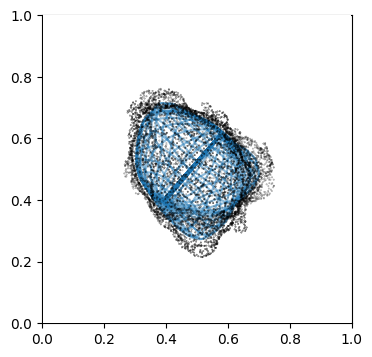

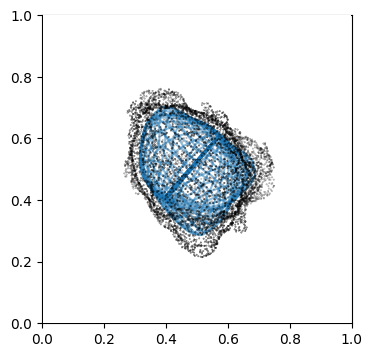

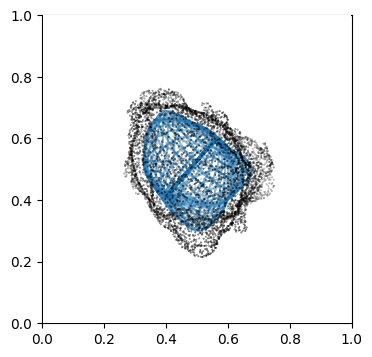

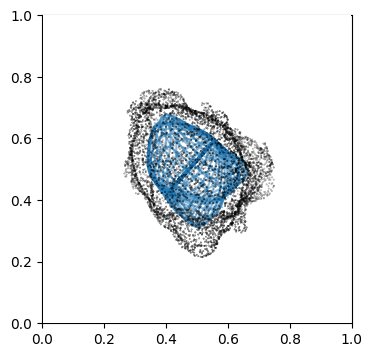

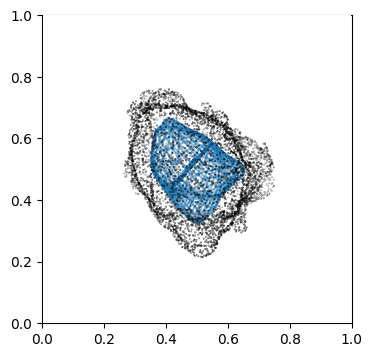

In [4]:
# use matplotlib and plot every 10th iteration wireframe surface to see the effect relative to the surface mesh with this inside surface propagation  
"""
Visualize second the propagation inwards which is from slice 0 to N_in+1, in reverse order.
"""
Suv_prop_inside = topography_space[:N_in+1][::-1] # remember to reverse order 

sampling = 5

for ii in np.arange(0, len(Suv_prop_inside), sampling):
    fig, ax = plt.subplots(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')
    ax.set_box_aspect(aspect = (1,1,1)) # this works. 
    ax.scatter(surf_mesh.vertices[::sampling,0],
               surf_mesh.vertices[::sampling,1],
               surf_mesh.vertices[::sampling,2], color='k', s=0.1) # note the surface mesh vertices are inverse order to the image. 
    # plot the propagated surface.
    ax.plot_wireframe(Suv_prop_inside[ii][...,0], 
                      Suv_prop_inside[ii][...,1],
                      Suv_prop_inside[ii][...,2], rstride=16, cstride=16, alpha=0.5)
    ax.axis('off')
    ax.grid('off')
    plt.show()

#### 3. Mapping measurements of $V(x,y,z)$ into the topographic space $(d,u,v)$

The constructed `topography_space`, is an array of dimensions, $(D,U,V,3)$ whereby the 3 channels correspond to the Cartesian $(x,y,z)$ coordinates i.e. for every voxel of $(d,u,v)$ space, we know its corresponding $(x,y,z) coordinate. Specifically, we have constructed a mapping of a `shell` volume around $S_{ref}(x,y,z)$. 

We can use `topography_space` with interpolation to pullback and visualize any scalar or label quantity of interest of Cartesian $(x,y,z)$ space in topographic $(d,u,v)$ space with the huge huge advantage of seeing everything in the vicinity of the cell surface in a single field-of-view !   

##### a. Visualizing the Cartesian $(x,y,z)$ space mapped by topography $(d,u,v)$ space 

We will assign a sequential coloring scheme to each $(d,u,v)$ coordinate and visualize the same coloring displayed on its corresponding $(x,y,z)$ position given by `topography_space`.

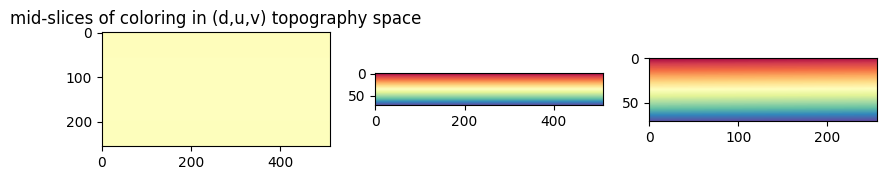

In [5]:
"""
Generate coloring of the (d,u,v) space
"""
import unwrap3D.Visualisation.colors as vol_colors
from matplotlib import cm 

topographic_space_index = np.arange(np.prod(topography_space.shape[:3])).reshape(topography_space.shape[:3])
topographic_space_color = np.uint8(255*vol_colors.get_colors(topographic_space_index,
                                                             colormap=cm.Spectral)[...,:3])

# check the mid-slices of the colormap to see how it looks in the three orthogonal views.
topography_size = topography_space.shape[:3]

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.title('mid-slices of coloring in (d,u,v) topography space')
plt.imshow(topographic_space_color[topography_size[0]//2,:,:])
plt.subplot(132)
plt.imshow(topographic_space_color[:,topography_size[1]//2,:])
plt.subplot(133)
plt.imshow(topographic_space_color[:,:,topography_size[2]//2])
plt.show()

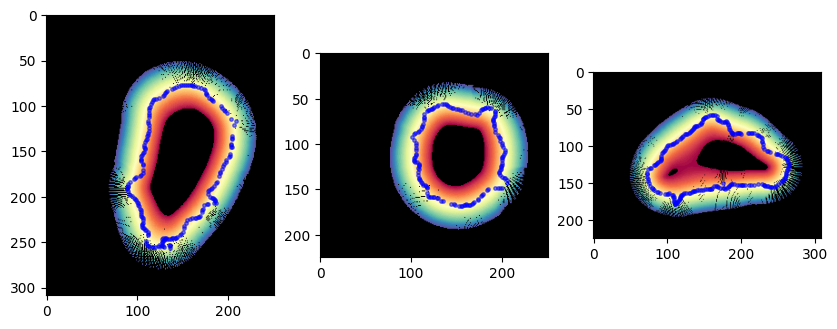

In [6]:
"""
Put the topographic coordinates, in their corresponding (x,y,z) coordinate and rasterized onto the image grid for display.
"""
# Now we initialise an array based on the size of the original cartesian volume image
topographic_cartesian_color = np.zeros(binary_img.shape[:3][::-1]+(3,), dtype=np.uint8) # note the [::-1] is only because the original cell surface mesh was extracted after transposing the image

#populate the color using the topographic coordinates. for simplicity we cast the float to int.
topographic_cartesian_color[topography_space[...,0].ravel().astype(np.int32), 
                            topography_space[...,1].ravel().astype(np.int32), 
                            topography_space[...,2].ravel().astype(np.int32)] = topographic_space_color.reshape(-1,3)

img_size = binary_img.shape[:3][::-1] # the mesh was derived from the image transpose


# Now we take a look at the topography space mapped into the volume, with the mesh points corresponding to the same slice overlaid
# We see the covering is good except as expected the North/South poles where we expect undersampling. 
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(topographic_cartesian_color[img_size[0]//2,:,:])
# map all the points of mesh in this view in 2D
select_pts = np.logical_and(surf_mesh.vertices[...,0]>img_size[0]//2-0.5, 
                            surf_mesh.vertices[...,0]<img_size[0]//2+0.5)
plt.plot(surf_mesh.vertices[select_pts,2], 
         surf_mesh.vertices[select_pts,1], '.', ms=5., color='b', alpha=0.5) 
plt.subplot(132)
plt.imshow(topographic_cartesian_color[:,img_size[1]//2,:])
# map all the points of mesh in this view in 2D
select_pts = np.logical_and(surf_mesh.vertices[...,1]>img_size[1]//2-0.5, 
                            surf_mesh.vertices[...,1]<img_size[1]//2+0.5)
plt.plot(surf_mesh.vertices[select_pts,2], 
         surf_mesh.vertices[select_pts,0], '.', ms=5., color='b', alpha=0.5) 
plt.subplot(133)
plt.imshow(topographic_cartesian_color[:,:,img_size[2]//2])
select_pts = np.logical_and(surf_mesh.vertices[...,2]>img_size[2]//2-0.5, 
                            surf_mesh.vertices[...,2]<img_size[2]//2+0.5)
plt.plot(surf_mesh.vertices[select_pts,1], 
         surf_mesh.vertices[select_pts,0], '.', ms=5., color='b', alpha=0.5) 
plt.show()



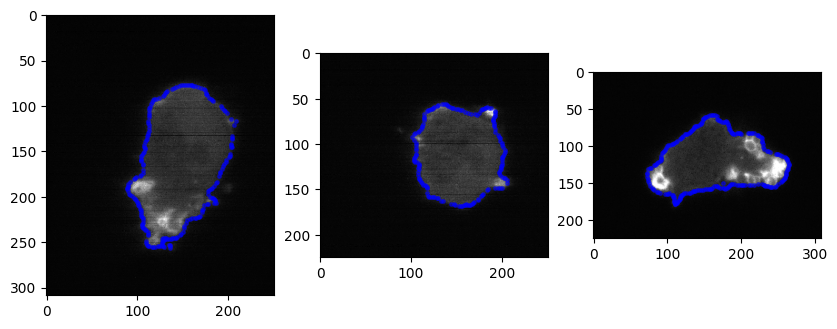

In [7]:
# we can also overlay the mesh with the cross-sections of the actual image too

img_transpose = img.transpose(2,1,0).copy()

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(img_transpose[img_transpose.shape[0]//2,:,:], cmap='gray')
select_pts = np.logical_and(surf_mesh.vertices[...,0]>img_size[0]//2-0.5, 
                            surf_mesh.vertices[...,0]<img_size[0]//2+0.5)
plt.plot(surf_mesh.vertices[select_pts,2], 
         surf_mesh.vertices[select_pts,1], '.', ms=5., color='b', alpha=0.5) 
plt.subplot(132)
plt.imshow(img_transpose[:,img_transpose.shape[1]//2,:], cmap='gray')
# map all the points of mesh in this view in 2D
select_pts = np.logical_and(surf_mesh.vertices[...,1]>img_size[1]//2-0.5, 
                            surf_mesh.vertices[...,1]<img_size[1]//2+0.5)
plt.plot(surf_mesh.vertices[select_pts,2], 
         surf_mesh.vertices[select_pts,0], '.', ms=5., color='b', alpha=0.5) 
plt.subplot(133)
plt.imshow(img_transpose[:,:,img_transpose.shape[2]//2], cmap='gray')
select_pts = np.logical_and(surf_mesh.vertices[...,2]>img_size[2]//2-0.5, 
                            surf_mesh.vertices[...,2]<img_size[2]//2+0.5)
plt.plot(surf_mesh.vertices[select_pts,1], 
         surf_mesh.vertices[select_pts,0], '.', ms=5., color='b', alpha=0.5) 
plt.show()


##### b. Mapping the original image into a topographic volume image

In [8]:
import unwrap3D.Image_Functions.image as image_fn

topographic_I = np.uint16(image_fn.map_intensity_interp3(topography_space.reshape(-1,3)[...,::-1], # again the ::-1 to reverse the coordinates, so they map correctly to the cell in the original image 
                                                       grid_shape=img.shape, 
                                                       I_ref=img))
topographic_I = topographic_I.reshape(topography_space.shape[:-1])

# we can save this for viewing 
skio.imsave(os.path.join(savefolder, 'topographic_intensity_I_img.tif'), 
            np.uint16(topographic_I))

img_size = img.shape[:3] # redefining image size, because we choose to flip the coordinates of topography space

C:\Users\fyz11\AppData\Local\Temp\ipykernel_2320\3525422746.py:9: UserWarning: example_results\bleb_example\step5_topographic_space\topographic_intensity_I_img.tif is a low contrast image
  skio.imsave(os.path.join(savefolder, 'topographic_intensity_I_img.tif'),


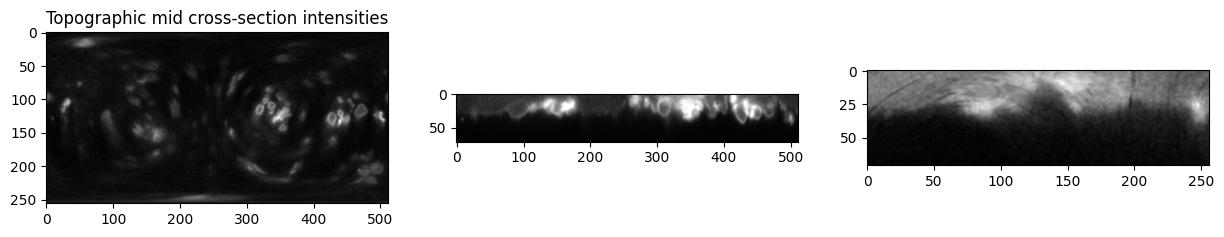

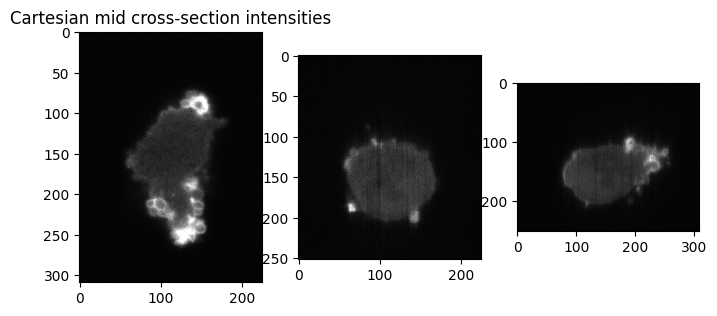

In [9]:
# visualize the mid cross sections of topographic and original cartesian.
# Note the upside-down of the image: this is because we use the convention 1st d slice = innermost of cell, last d slice = outermost of cell

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Topographic mid cross-section intensities')
plt.imshow(topographic_I[topography_size[0]//2,:,:], cmap='gray')
plt.subplot(132)
plt.imshow(topographic_I[:,topography_size[1]//2,:], cmap='gray')
plt.subplot(133)
plt.imshow(topographic_I[:,:,topography_size[2]//2], cmap='gray')
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(131)
plt.title('Cartesian mid cross-section intensities')
plt.imshow(img[img_size[0]//2,:,:], cmap='gray')
plt.subplot(132)
plt.imshow(img[:,img_size[1]//2,:], cmap='gray')
plt.subplot(133)
plt.imshow(img[:,:,img_size[2]//2], cmap='gray')
plt.show()

##### c. Mapping the binary cell segmentation into a topographic binary image

We can also map label measurements, not necessarily just scalar measurements. For labels, we use nearest neighbor interpolation by setting `method='nearest'` in `unwrap3D.Image_Functions.image.map_intensity_interp3`.

Alternatively, for binary segmentation we can make it uint8 i.e. 0 = background, 255 = cell, interpolate, then re-binarize the output with cutoff of 128.

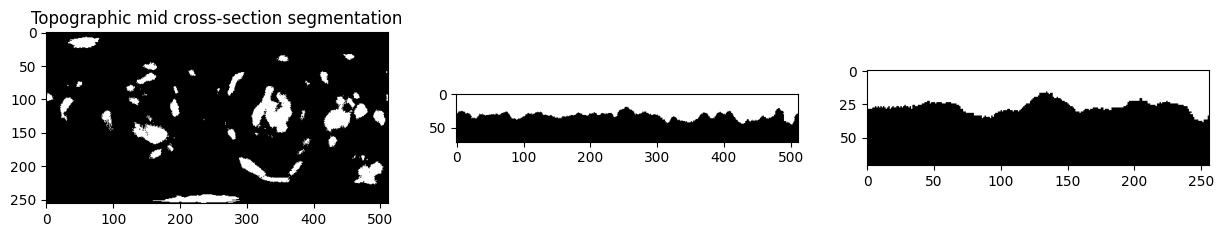

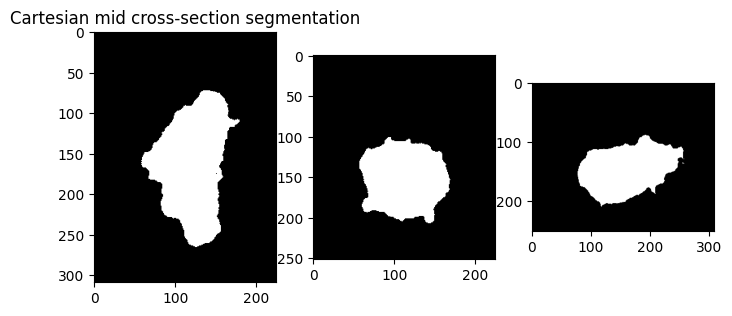

In [10]:
import unwrap3D.Image_Functions.image as image_fn

topographic_binary = np.uint16(image_fn.map_intensity_interp3(topography_space.reshape(-1,3)[...,::-1], # again the ::-1 to reverse the coordinates, so they map correctly to the cell in the original image 
                                                       grid_shape=binary_img.shape, 
                                                       method='nearest',
                                                       I_ref=binary_img))
topographic_binary = topographic_binary.reshape(topography_space.shape[:-1])

# visualize the mid cross sections of topographic and original cartesian.
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Topographic mid cross-section segmentation')
plt.imshow(topographic_binary[topography_size[0]//2,:,:], cmap='gray')
plt.subplot(132)
plt.imshow(topographic_binary[:,topography_size[1]//2,:], cmap='gray')
plt.subplot(133)
plt.imshow(topographic_binary[:,:,topography_size[2]//2], cmap='gray')
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(131)
plt.title('Cartesian mid cross-section segmentation')
plt.imshow(binary_img[img_size[0]//2,:,:], cmap='gray')
plt.subplot(132)
plt.imshow(binary_img[:,img_size[1]//2,:], cmap='gray')
plt.subplot(133)
plt.imshow(binary_img[:,:,img_size[2]//2], cmap='gray')
plt.show()

In [11]:
# Finally we save the constructed topographic coordinates - we will use this next to map the original segmentation binary and derive a topographic surface mesh

"""
Save the basic parameters for replication. 
"""
spio.savemat(os.path.join(savefolder, 
                          'topographic_volume_space.mat'), 
             {'topographic_map': topography_space.astype(np.float32), 
              'uv_map_file': uv_file, 
              'N_inside': N_in, 
              'N_outside': N_out,
              'alpha_step': alpha_step}) 